## **Asssignment1-PART-D - Topic-based Sentiment Analysis with a Real Dataset**

In [ ]:
#libraries imported
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model
from keras.utils import plot_model


### Downloading and preprocessing data

In [ ]:
#downloading datasets 
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)

downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016devtest-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016dev-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016test-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016train-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2015test-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2015train-BD.tsv')

downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/gold/SemEval2017-task4-test.subtask-BD.english.txt')

#Preprocessing the data
with open('twitter-2016dev-BD.tsv', 'r') as f:
  dev_original = [l.strip().split('\t') for l in f.readlines()]
with open('SemEval2017-task4-test.subtask-BD.english.txt', 'r') as f:
  test_original = [l.strip().split('\t') for l in f.readlines()]
train_original = []
with open('twitter-2016train-BD.tsv', 'r') as f:
  train_original = [l.strip().split('\t') for l in f.readlines()]
with open('twitter-2016test-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines()])
with open('twitter-2016devtest-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines()])
with open('twitter-2015test-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines() if l.strip().split('\t')[2] in ['negative','positive']])
with open('twitter-2015train-BD.tsv', 'r') as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines() if l.strip().split('\t')[2] in ['negative','positive']])

print("Training entries: {}".format(len(train_original)))
print("Development entries: {}".format(len(dev_original)))
print("Testing entries: {}".format(len(test_original)))

Training entries: 17639
Development entries: 1325
Testing entries: 6185


We now can start playing around with the data, let’s first see some examples:

In [ ]:
print("ID \t TOPIC \t LABLE \t TWEET_TEXT")
print(train_original[0])
print(train_original[1])
print(train_original[2])
print(train_original[3])
print(train_original[4])

ID 	 TOPIC 	 LABLE 	 TWEET_TEXT
['628949369883000832', '@microsoft', 'negative', "dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon."]
['628976607420645377', '@microsoft', 'negative', "@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!"]
['629023169169518592', '@microsoft', 'negative', "I may be ignorant on this issue but... should we celebrate @Microsoft's parental leave changes? Doesn't the gender divide suggest... (1/2)"]
['629179223232479232', '@microsoft', 'negative', 'Thanks to @microsoft, I just may be switching over to @apple.']
['629226490152914944', '@microsoft', 'positive', 'Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft']


Build a vocabulary based on the training dataset. 

In [ ]:
#building a corpus for training data
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in train_original:
  topic_tokens = text_to_word_sequence(example[1])
  text_tokens = text_to_word_sequence(example[3])
  voc.extend(topic_tokens)
  voc.extend(text_tokens)
voc = set(voc)
print(len(voc))

#assigning word index to each word
word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(len(word_index))

32571
32575


In [ ]:
# Please write your code to generate the following data

##### your code goes here:

#FOR TRAIN DATA
x_train_tweet = []
x_train_topic = []
for example in train_original:
  #converting train tweet text and topic words to word tokens
  x_train_topic.append(text_to_word_sequence(example[1]))
  x_train_tweet.append(text_to_word_sequence(example[3]))
#convert train tweet text and topic words to integers
x_train_tweet_int = [[word_index[train_tweet_token] if train_tweet_token in word_index.keys() else 2 for train_tweet_token in train_tweet] for train_tweet in x_train_tweet]
x_train_topic_int = [[word_index[train_topic_token] if train_topic_token in word_index.keys() else 2 for train_topic_token in train_topic] for train_topic in x_train_topic]

#FOR DEV DATA
x_dev_tweet= []
x_dev_topic =[]
for example in dev_original:
  #converting dev tweet text and topic words to word tokens
  x_dev_topic.append(text_to_word_sequence(example[1]))
  x_dev_tweet.append(text_to_word_sequence(example[3]))
#convert dev tweet text and topic words to integers
x_dev_tweet_int = [[word_index[dev_tweet_token] if dev_tweet_token in word_index.keys() else 2 for dev_tweet_token in dev_tweet] for dev_tweet in x_dev_tweet]
x_dev_topic_int = [[word_index[dev_topic_token] if dev_topic_token in word_index.keys() else 2 for dev_topic_token in dev_topic] for dev_topic in x_dev_topic]

#FOR TEST DATA
x_test_tweet = []
x_test_topic = []
for example in test_original:
  #converting test tweet text and topic words to word tokens
  x_test_topic.append(text_to_word_sequence(example[1]))
  x_test_tweet.append(text_to_word_sequence(example[3]))
#convert test tweet text and topic words to integers
x_test_tweet_int = [[word_index[test_tweet_token] if test_tweet_token in word_index.keys() else 2 for test_tweet_token in test_tweet] for test_tweet in x_test_tweet]
x_test_topic_int = [[word_index[test_topic_token] if test_topic_token in word_index.keys() else 2 for test_topic_token in test_topic] for test_topic in x_test_topic]


# If use the previous word_index, you can get a print result like:
assert len(x_train_topic) == len(train_original)
assert len(x_train_topic) == len(x_train_topic_int)
assert len(x_test_topic) == len(test_original)
assert len(x_test_topic) == len(x_test_topic_int)
print("x_dev_tweet[0]:")
print(x_dev_tweet[0])
print("x_dev_topic[0]:")
print(x_dev_topic[0])
print("x_dev_tweet_int[0]:")
print(x_dev_tweet_int[0])
print("x_dev_topic_int[0]:")
print(x_dev_topic_int[0])

x_dev_tweet[0]:
['jay', 'z', 'joins', 'instagram', 'with', 'nostalgic', 'tribute', 'to', 'michael', 'jackson', 'jay', 'z', 'apparently', 'joined', 'instagram', 'on', 'saturday', 'and', 'http', 't', 'co', 'qj9i4ecvxy']
x_dev_topic[0]:
['michael', 'jackson']
x_dev_tweet_int[0]:
[674, 25017, 28585, 26023, 24839, 28440, 30650, 20697, 16532, 7837, 674, 25017, 28165, 6387, 26023, 4635, 13655, 10493, 23139, 8910, 4297, 2]
x_dev_topic_int[0]:
[16532, 7837]


In [ ]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append(0)
    else:
      y.append(1)
  return y
  
y_train = label2int(train_original)
y_dev = label2int(dev_original)
y_test = label2int(test_original)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

0
0
0
0
1


In [ ]:
# Please write your code to combine the x_*_tweet and x_*_topic into the following varibles
# Tips: 
# 1) We can use the special token <START> to concatenate the tweets and topics.
# 2) After combine them, do not foget to pad the sequences.

from keras.preprocessing.sequence import pad_sequences
##### your code goes here:

#FOR TRAIN DATA (x_train, x_train_int)
x_train = []
for train in range(len(train_original)):
  train_word = [tr_data for tr_data in x_train_topic[train]]
  train_word.append(["<START>"])
  for train_sent in x_train_tweet[train]:
    train_word.append(train_sent)
  x_train.append(train_word)

x_train_int = []
for train_int in range(len(x_train_topic_int)):
  train_int_word = [word_index[tr_data] for tr_data in x_train_topic[train_int]]
  train_int_word.append(word_index["<START>"])
  for sent_idx in x_train_tweet_int[train_int]:
    train_int_word.append(sent_idx)
  x_train_int.append(train_int_word)

#FOR DEV DATA (x_dev, x_dev_int)
x_dev = []
for dev in range(len(dev_original)):
  dev_word = [dv_data for dv_data in x_dev_topic[dev]]
  dev_word.append(["<START>"])
  for dev_sent in x_dev_tweet[dev]:
    dev_word.append(dev_sent)
  x_dev.append(dev_word)

x_dev_int = []
for c in range(len(x_dev_topic_int)):
  for d in x_dev_topic_int[c]:
    dev_idx=[]
    dev_idx.append(d)
    dev_idx.append(word_index["<START>"])
    for f in x_dev_tweet_int[c]:
      dev_idx.append(f)
  x_dev_int.append(dev_idx)

#FOR TEST DATA (x_test, x_test_int)
x_test = []
for test in range(len(test_original)):
  test_word = [te_data for te_data in x_test_topic[test]]
  test_word.append(["<START>"])
  for test_sent in x_test_tweet[test]:
    test_word.append(test_sent)
  x_test.append(test_word)

x_test_int = []
for x in range(len(x_test_topic_int)):
  for y in x_test_topic_int[x]:
    test_idx=[]
    test_idx.append(y)
    test_idx.append(word_index["<START>"])
    for z in x_test_tweet_int[x]:
      test_idx.append(z)
  x_test_int.append(test_idx)

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles

#Padding the train, dev, test interger sequences
x_train_pad = pad_sequences(x_train_int, value=word_index["<PAD>"], padding='post', maxlen=128)
x_dev_pad = pad_sequences(x_dev_int, value=word_index["<PAD>"], padding='post', maxlen=128)
x_test_pad = pad_sequences(x_test_int, value=word_index["<PAD>"], padding='post', maxlen=128)
#Wrapping the output of the pad sequences
x_train_pad = np.array(x_train_pad)
x_dev_pad = np.array(x_dev_pad)
x_test_pad = np.array(x_test_pad)

print("Before paded:")
print(x_train[0])
print(x_train_int[0])
print("After paded:")
print(x_train_pad[0])

Before paded:
['microsoft', ['<START>'], 'dear', 'microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', 'but', 'no', 'lync', 'update', "c'mon"]
[10949, 1, 26975, 10949, 5713, 11669, 20548, 16414, 12671, 10575, 10493, 27379, 28282, 22273, 7209, 24381, 12141]
After paded:
[10949     1 26975 10949  5713 11669 20548 16414 12671 10575 10493 27379
 28282 22273  7209 24381 12141     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0  

#**Model 1: Previous models without pre-trained word embeddings**

## **Model 1-1: Neural bag of words without pre-trained word embeddings**

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


In [ ]:
# your code goes here

#sequential library is used to add layer one by one
model1a = Sequential()
#first layer --> embedding layer
model1a.add(Embedding(input_length= 128, input_dim= 32575, output_dim= 100))
#second layer --> globalpooling layer
model1a.add(GlobalAveragePooling1DMasked())
#third layer --> dense layer1
model1a.add(Dense(16, activation='sigmoid'))
#fourth layer --> output layer
model1a.add(Dense(1, activation='sigmoid'))

model1a.summary()

#compiling the model
model1a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 100)          3257500   
_________________________________________________________________
global_average_pooling1d_mas (None, 100)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 17        
Total params: 3,259,133
Trainable params: 3,259,133
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training to monitor the model loss and accuracy on validation set
history1a = model1a.fit(x_train_pad, y_train, epochs=40, batch_size=512, validation_data=(x_dev_pad, y_dev), verbose=1)

Epoch 1/40
35/35 [==============================] - 2s 32ms/step - loss: 0.7898 - accuracy: 0.2254 - val_loss: 0.6586 - val_accuracy: 0.7442
Epoch 2/40
35/35 [==============================] - 1s 29ms/step - loss: 0.6148 - accuracy: 0.7892 - val_loss: 0.5727 - val_accuracy: 0.7442
Epoch 3/40
35/35 [==============================] - 1s 29ms/step - loss: 0.5224 - accuracy: 0.7907 - val_loss: 0.5683 - val_accuracy: 0.7442
Epoch 4/40
35/35 [==============================] - 1s 29ms/step - loss: 0.5026 - accuracy: 0.7942 - val_loss: 0.5701 - val_accuracy: 0.7442
Epoch 5/40
35/35 [==============================] - 1s 29ms/step - loss: 0.5033 - accuracy: 0.7912 - val_loss: 0.5688 - val_accuracy: 0.7442
Epoch 6/40
35/35 [==============================] - 1s 29ms/step - loss: 0.5046 - accuracy: 0.7881 - val_loss: 0.5667 - val_accuracy: 0.7442
Epoch 7/40
35/35 [==============================] - 1s 29ms/step - loss: 0.4985 - accuracy: 0.7901 - val_loss: 0.5641 - val_accuracy: 0.7442
Epoch 8/40
35

In [ ]:
#evaluate on the test data
results = model1a.evaluate(x_test_pad, y_test)

194/194 [==============================] - 0s 2ms/step - loss: 0.5059 - accuracy: 0.7528


In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.27-cp37-none-any.whl size=7332 sha256=40f32ac03ce19ea56f40087053b042cf7a5d403c6d2b65bc3171b7f62596a9da
  Stored in directory: /root/.cache/pip/wheels/38/9e/e3/6cde1b6b6141b044c692d88980f26c4fe7806cc92ddd009c8c
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.24-cp37-none-any.whl size=6999 sha256=8300b93481ba773c339f1cb1502e4d6ec69aa4dc78653b464b744d0cd41b5864
  Stored in directory: /root/.cache/pip/wheels/0c/3b/5d/f2fb3eff7f2fe268463b91a825816a07cd8458c4fe359f034a
  Created wheel for compress-json: filename=compress_json-1.0.4-cp37-none-any.whl size=4586 sha256=04d7b2f00ae9a931f8147629f9d0e17b8c0010e49d5c548480b6d10133967771
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


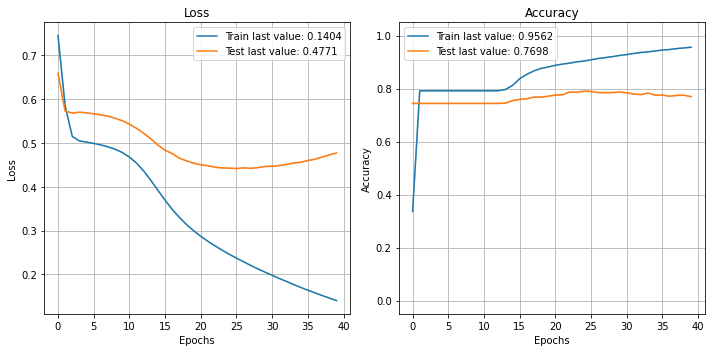

In [ ]:
# your code goes here
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

#plotting
plot_history(history1a.history, path="standard.png")
plt.show()

The accuracy of the lab4 model2 in this task is around 78%. 

##  **Model 1-2: CNN without pre-trained word embeddings**

In [ ]:
from keras.layers import Conv1D


# your code goes here

#sequential library is used to add layer one by one
model1b = Sequential()
#first layer --> embedding layer
model1b.add(Embedding(input_length= 128, input_dim= 32575, output_dim= 120))
#second layer --> first convolutional layer
model1b.add(Conv1D(128, kernel_size = 8, activation="relu", strides=3))
#third layer --> dense layer1
model1b.add(Dense(16, activation='sigmoid'))
#fourth layer --> dense layer
model1b.add(Dense(1, activation='sigmoid'))

#compiling the model
model1b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1b.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 120)          3909000   
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           123008    
_________________________________________________________________
dense_2 (Dense)              (None, 41, 16)            2064      
_________________________________________________________________
dense_3 (Dense)              (None, 41, 1)             17        
Total params: 4,034,089
Trainable params: 4,034,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training to monitor the model loss and accuracy on validation set
history1b = model1b.fit(x_train_pad, y_train, epochs=40, batch_size=512, validation_data=(x_dev_pad, y_dev), verbose=1)

Epoch 1/40
35/35 [==============================] - 30s 47ms/step - loss: 0.5136 - accuracy: 0.7916 - val_loss: 0.5747 - val_accuracy: 0.7442
Epoch 2/40
35/35 [==============================] - 1s 40ms/step - loss: 0.5120 - accuracy: 0.7882 - val_loss: 0.5640 - val_accuracy: 0.7461
Epoch 3/40
35/35 [==============================] - 1s 40ms/step - loss: 0.4884 - accuracy: 0.8005 - val_loss: 0.5577 - val_accuracy: 0.7489
Epoch 4/40
35/35 [==============================] - 1s 40ms/step - loss: 0.4732 - accuracy: 0.8093 - val_loss: 0.5567 - val_accuracy: 0.7474
Epoch 5/40
35/35 [==============================] - 1s 40ms/step - loss: 0.4685 - accuracy: 0.8116 - val_loss: 0.5722 - val_accuracy: 0.7462
Epoch 6/40
35/35 [==============================] - 1s 40ms/step - loss: 0.4558 - accuracy: 0.8193 - val_loss: 0.5677 - val_accuracy: 0.7440
Epoch 7/40
35/35 [==============================] - 1s 40ms/step - loss: 0.4527 - accuracy: 0.8207 - val_loss: 0.5722 - val_accuracy: 0.7435
Epoch 8/40
3

In [ ]:
#evaluate on the test data
results = model1b.evaluate(x_test_pad, y_test)

194/194 [==============================] - 1s 4ms/step - loss: 1.1908 - accuracy: 0.7213
[1.190783977508545, 0.7212611436843872]


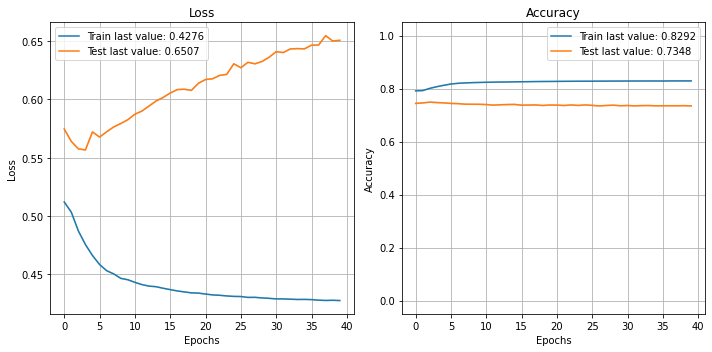

In [ ]:
#plotting
plot_history(history1b.history, path="standard.png")
plt.show()

# **Model 2: Using pre-trained word embeddings**

### Preparing pre-trained word embeddings (GLOVE)

In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip /content/glove.6B.zip

--2021-03-04 03:26:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-04 03:26:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-04 03:26:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


### Convert the data to GLOVE word index

In [ ]:
print(wordToIndex["you"])
print(indexToWord[394475])
print(word_index["you"])

394475
you
23164


In [ ]:
# Please write your code to generate the following data
##### your code goes here:

#FOR TRAIN DATA (x_train_tweet_glove, x_train_topic_glove)
#convert train tweet text and topic words to integers and token
x_train_tweet_glove = [[wordToIndex[train_tweet_glove] if train_tweet_glove in wordToIndex.keys() else 2 for train_tweet_glove in train_tweet] for train_tweet in x_train_tweet]
x_train_topic_glove = [[wordToIndex[train_topic_glove] if train_topic_glove in wordToIndex.keys() else 2 for train_topic_glove in train_topic] for train_topic in x_train_topic]

#FOR DEV DATA (x_dev_tweet_glove, x_dev_topic_glove)
#convert dev tweet text and topic words to integers and token
x_dev_tweet_glove = [[wordToIndex[dev_tweet_glove] if dev_tweet_glove in wordToIndex.keys() else 2 for dev_tweet_glove in dev_tweet] for dev_tweet in x_dev_tweet]
x_dev_topic_glove = [[wordToIndex[dev_topic_glove] if dev_topic_glove in wordToIndex.keys() else 2 for dev_topic_glove in dev_topic] for dev_topic in x_dev_topic]

#FOR TEST DATA (x_test_tweet_glove, x_test_topic_glove)
#convert test tweet text and topic words to integers and token
x_test_tweet_glove = [[wordToIndex[test_tweet_glove] if test_tweet_glove in wordToIndex.keys() else 2 for test_tweet_glove in test_tweet] for test_tweet in x_test_tweet]
x_test_topic_glove = [[wordToIndex[test_topic_glove] if test_topic_glove in wordToIndex.keys() else 2 for test_topic_glove in test_topic] for test_topic in x_test_topic]

# You should get a print result like:
assert len(x_train_tweet_glove) == len(train_original)
assert len(x_train_topic_glove) == len(x_train_topic_int)
assert len(x_test_tweet_glove) == len(test_original)
assert len(x_test_topic_glove) == len(x_test_topic_int)
print("x_dev_tweet_glove[0]:")
print(x_dev_tweet_glove[0])
print("x_dev_topic_glove[0]:")
print(x_dev_topic_glove[0])

x_dev_tweet_glove[0]:
[196237, 395262, 198486, 190716, 388711, 264529, 365027, 360915, 242891, 194733, 196237, 395262, 57698, 198478, 190716, 269798, 319134, 54718, 182915, 350784, 103530, 2]
x_dev_topic_glove[0]:
[242891, 194733]


As before, we concatenate the tweets and topics for fitting in the previous model. Let us do it again for GLOVE version variables.

In [ ]:
# Please write your code to combine the x_*_tweet_glove and x_*_topic_glove into the following varibles
# Tips: 
# 1) There is no <START> token in GLOVE. Here we can use integer 1 to concatenate.
# 2) After combine them, do not foget to pad the sequences.

##### your code goes here:
#combining the tweet and the topic
x_train_glove = [train_glove+ train_token for train_glove, train_token in zip(x_train_topic_glove, [[1]+ train_token for train_token in x_train_tweet_glove])]
x_dev_glove = [dev_glove+ dev_token for dev_glove, dev_token in zip(x_dev_topic_glove, [[1]+ dev_token for dev_token in x_dev_tweet_glove])]
x_test_glove = [test_glove+ test_token for test_glove, test_token in zip(x_test_topic_glove, [[1]+ test_token for test_token in x_test_tweet_glove])]

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles

#Padding the train, dev, test interger sequences
x_train_pad_glove = pad_sequences(x_train_glove, value=word_index["<PAD>"], padding='post', maxlen=128)
x_dev_pad_glove = pad_sequences(x_dev_glove, value=word_index["<PAD>"], padding='post', maxlen=128)
x_test_pad_glove = pad_sequences(x_test_glove, value=word_index["<PAD>"], padding='post', maxlen=128)
#Wrapping the output of the pad sequences
x_train_pad_glove = np.array(x_train_pad_glove)
x_dev_pad_glove = np.array(x_dev_pad_glove)
x_test_pad_glove = np.array(x_test_pad_glove)

print("Before paded:")
print(x_train_glove[0])
print("After paded:")
print(x_train_pad_glove[0])

Before paded:
[243317, 1, 118309, 243317, 357266, 2, 151349, 229153, 192973, 166369, 54718, 51582, 87775, 262350, 228306, 373375, 88558]
After paded:
[243317      1 118309 243317 357266      2 151349 229153 192973 166369
  54718  51582  87775 262350 228306 373375  88558      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      

## **Model 2-1: Neural bag of words using pre-trained word embeddings**

In [ ]:
# your code goes here
# Tips: Do not misuse the training data
hidden_layer=16

#sequential library is used to add layer one by one
model2a = Sequential()
#first layer --> pre-trained embedding layer
model2a.add(createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False))
#second layer --> globalpooling layer
model2a.add(GlobalAveragePooling1DMasked())
#third layer --> dense layer with 16 hidden layers
model2a.add(Dense(hidden_layer, activation="sigmoid", name="hidden_layer"))
#fourth layer --> output layer
model2a.add(Dense(1, activation='sigmoid'))

model2a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2a.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GloVe_Embeddings (Embedding) (None, None, 300)         120000300 
_________________________________________________________________
global_average_pooling1d_mas (None, 300)               0         
_________________________________________________________________
hidden_layer (Dense)         (None, 16)                4816      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 120,005,133
Trainable params: 4,833
Non-trainable params: 120,000,300
_________________________________________________________________


In [ ]:
#Training to monitor the model loss and accuracy on validation set
history2a = model2a.fit(x_train_pad_glove, y_train, epochs=200, batch_size=512, validation_data=(x_dev_pad_glove, y_dev), verbose=1)

Epoch 1/200
35/35 [==============================] - 1s 24ms/step - loss: 1.0675 - accuracy: 0.2051 - val_loss: 0.8717 - val_accuracy: 0.2558
Epoch 2/200
35/35 [==============================] - 1s 21ms/step - loss: 0.8575 - accuracy: 0.2044 - val_loss: 0.7385 - val_accuracy: 0.2558
Epoch 3/200
35/35 [==============================] - 1s 20ms/step - loss: 0.7174 - accuracy: 0.3376 - val_loss: 0.6579 - val_accuracy: 0.7321
Epoch 4/200
35/35 [==============================] - 1s 21ms/step - loss: 0.6316 - accuracy: 0.7863 - val_loss: 0.6114 - val_accuracy: 0.7442
Epoch 5/200
35/35 [==============================] - 1s 21ms/step - loss: 0.5794 - accuracy: 0.7894 - val_loss: 0.5863 - val_accuracy: 0.7442
Epoch 6/200
35/35 [==============================] - 1s 20ms/step - loss: 0.5473 - accuracy: 0.7906 - val_loss: 0.5741 - val_accuracy: 0.7442
Epoch 7/200
35/35 [==============================] - 1s 20ms/step - loss: 0.5276 - accuracy: 0.7922 - val_loss: 0.5693 - val_accuracy: 0.7442
Epoch 

In [ ]:
#testing
results = model2a.evaluate(x_test_pad_glove, y_test)

194/194 [==============================] - 0s 2ms/step - loss: 0.4605 - accuracy: 0.7876


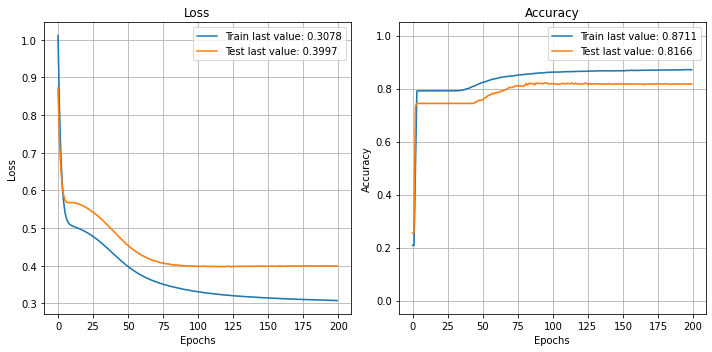

In [ ]:
#plot
plot_history(history2a.history, path="standard.png")
plt.show()

##  **Model 2-2: CNN or LSTM with pre-trained word embeddings**

Please try one more model (CNN or LSTM) with pre-trained word embeddings in here:

In [ ]:
#sequential library is used to add layer one by one
hidden_layer=16

model2b = Sequential()
#first layer --> pretrained embedding layer
model2b.add(createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False))
#second layer --> first convolutional layer
model2b.add(Conv1D(128, kernel_size = 8, activation="sigmoid", strides=3))
#third layer --> dense layer with 16 hidden layers
model2b.add(Dense(hidden_layer, activation="sigmoid", name="hidden_layer"))
#fourth layer --> output layer
model2b.add(Dense(1, activation='sigmoid'))

#compiling the model
model2b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2b.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GloVe_Embeddings (Embedding) (None, None, 300)         120000300 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         307328    
_________________________________________________________________
hidden_layer (Dense)         (None, None, 16)          2064      
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           17        
Total params: 120,309,709
Trainable params: 309,409
Non-trainable params: 120,000,300
_________________________________________________________________


In [ ]:
#Training to monitor the model loss and accuracy on validation set
history2b = model2b.fit(x_train_pad_glove, y_train, epochs=200, batch_size=512, validation_data=(x_dev_pad_glove, y_dev), verbose=1)

Epoch 1/200
35/35 [==============================] - 2s 34ms/step - loss: 0.5083 - accuracy: 0.7919 - val_loss: 0.5627 - val_accuracy: 0.7442
Epoch 2/200
35/35 [==============================] - 1s 29ms/step - loss: 0.5009 - accuracy: 0.7914 - val_loss: 0.5602 - val_accuracy: 0.7453
Epoch 3/200
35/35 [==============================] - 1s 29ms/step - loss: 0.4850 - accuracy: 0.8036 - val_loss: 0.5549 - val_accuracy: 0.7499
Epoch 4/200
35/35 [==============================] - 1s 28ms/step - loss: 0.4960 - accuracy: 0.7961 - val_loss: 0.5594 - val_accuracy: 0.7493
Epoch 5/200
35/35 [==============================] - 1s 28ms/step - loss: 0.4928 - accuracy: 0.7984 - val_loss: 0.5595 - val_accuracy: 0.7487
Epoch 6/200
35/35 [==============================] - 1s 28ms/step - loss: 0.4929 - accuracy: 0.7980 - val_loss: 0.5558 - val_accuracy: 0.7498
Epoch 7/200
35/35 [==============================] - 1s 28ms/step - loss: 0.4884 - accuracy: 0.8012 - val_loss: 0.5593 - val_accuracy: 0.7498
Epoch 

In [ ]:
#testing
results = model2b.evaluate(x_test_pad_glove, y_test)

194/194 [==============================] - 1s 4ms/step - loss: 1.2266 - accuracy: 0.7166
[1.2266383171081543, 0.7165723443031311]


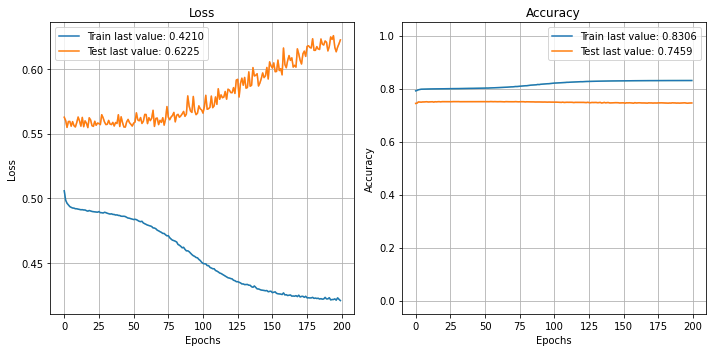

In [ ]:
#plot
plot_history(history2b.history, path="standard.png")
plt.show()

#  **Model 3: Model with multiple-input**

In [ ]:
# First of all, pad the tweet and topic separately
x_train_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_tweet_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_tweet_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_tweet_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_train_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_topic_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=16)

x_dev_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_topic_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

x_test_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_topic_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

## **Model 3-1 Neural bag of words model with multiple-input**

In [ ]:
# your code goes here
from keras.layers import concatenate

#first input
input1 = Input(shape=16)
#seconf input
input2 = Input(shape=128)
#building model1
embed1 = embeddingLayer(input1)
pool1 = GlobalAveragePooling1DMasked()(embed1)
dense1 = Dense(16, activation="sigmoid")(pool1)
model1 = Model(inputs=input1, outputs=dense1)
#building model2
embed2 = embeddingLayer(input2)
pool2 = GlobalAveragePooling1DMasked()(embed2)
dense2a = Dense(32, activation="sigmoid")(pool2)
model2 = Model(inputs=input2, outputs=dense2a)
#concatenate the output of the two models
combined = concatenate([model1.output, model2.output])
#output layer
out1a = Dense(16, activation="sigmoid")(combined)
final_out = Dense(1, activation="sigmoid")(out1a)
#building a final model
model3a = Model(inputs=[model1.input, model2.input], outputs=final_out)

model3a.summary()

#compiling the model
model3a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_masked (None, 300)          0           GloVe_Embeddings[0][0]     

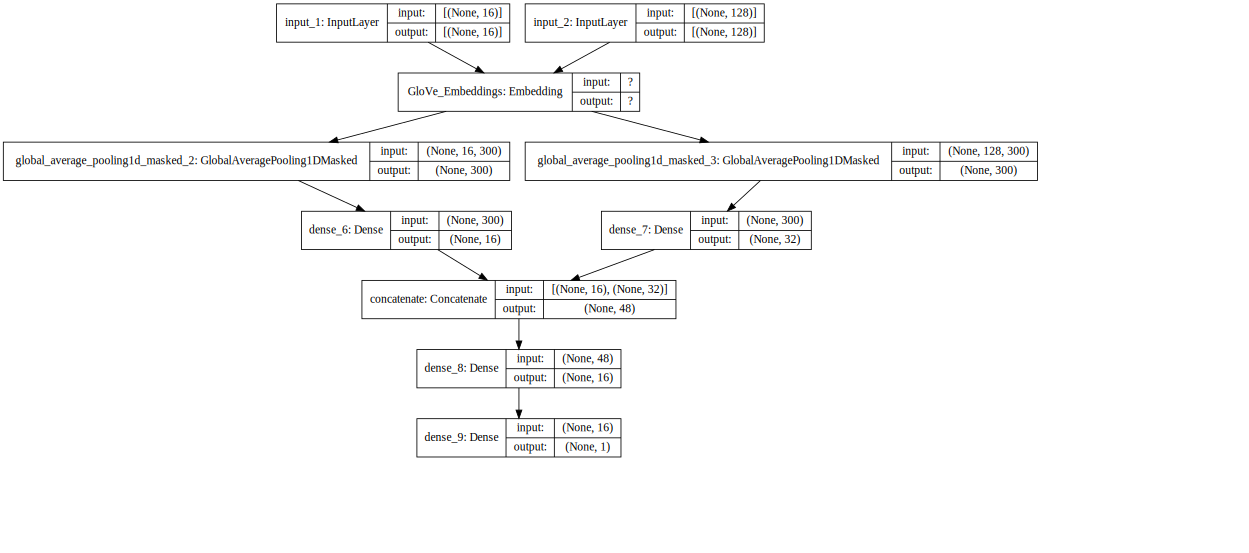

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model3a, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Train and evaluate your model:

In [ ]:
# your code goes here
#Training to monitor the model loss and accuracy on validation set
history3a = model3a.fit([x_train_topic_pad_glove, x_train_tweet_pad_glove], y_train, epochs=200, batch_size=512, validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev), verbose=1)

Epoch 1/200
35/35 [==============================] - 2s 25ms/step - loss: 0.7808 - accuracy: 0.3309 - val_loss: 0.5957 - val_accuracy: 0.7442
Epoch 2/200
35/35 [==============================] - 1s 22ms/step - loss: 0.5489 - accuracy: 0.7870 - val_loss: 0.5683 - val_accuracy: 0.7442
Epoch 3/200
35/35 [==============================] - 1s 22ms/step - loss: 0.5132 - accuracy: 0.7913 - val_loss: 0.5708 - val_accuracy: 0.7442
Epoch 4/200
35/35 [==============================] - 1s 22ms/step - loss: 0.5094 - accuracy: 0.7911 - val_loss: 0.5717 - val_accuracy: 0.7442
Epoch 5/200
35/35 [==============================] - 1s 21ms/step - loss: 0.5095 - accuracy: 0.7897 - val_loss: 0.5709 - val_accuracy: 0.7442
Epoch 6/200
35/35 [==============================] - 1s 21ms/step - loss: 0.4993 - accuracy: 0.7965 - val_loss: 0.5697 - val_accuracy: 0.7442
Epoch 7/200
35/35 [==============================] - 1s 21ms/step - loss: 0.4946 - accuracy: 0.7987 - val_loss: 0.5672 - val_accuracy: 0.7442
Epoch 

In [ ]:
#testing
results = model3a.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)

194/194 [==============================] - 1s 3ms/step - loss: 0.5294 - accuracy: 0.7738


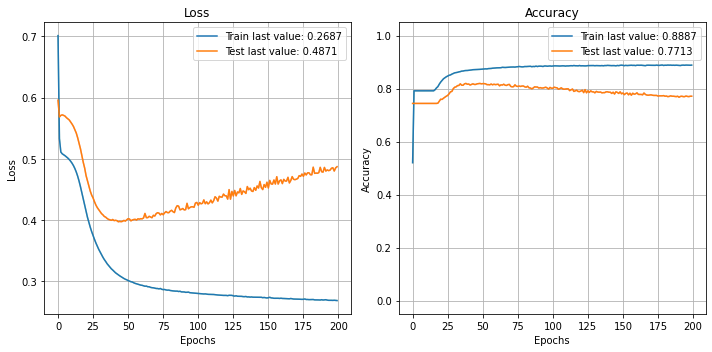

In [ ]:
#plot
plot_history(history3a.history, path="standard.png")
plt.show()

## **Model 3-2 CNN model with multiple-input**

In [ ]:
from keras.layers import Conv1D

#first input
input1 = Input(shape=16)
#second input
input2 = Input(shape=128)
#building model 1
embed1 = embeddingLayer(input1)
CNN_layer = Conv1D(100, kernel_size= 4, activation="sigmoid")(embed1)
CNN_layer1 = Conv1D(100, kernel_size= 4, activation="sigmoid")(CNN_layer)
pool1 = GlobalAveragePooling1DMasked()(CNN_layer1)
dense1a = Dense(16, activation="relu")(pool1)
dense1 = Dense(16, activation="relu")(dense1a)
model1 = Model(inputs=input1, outputs=dense1)
#building model 1
embed2 = embeddingLayer(input2)
CNN_layer2 = Conv1D(100, kernel_size= 4, activation="sigmoid")(embed2)
CNN_layer3 = Conv1D(100, kernel_size= 4, activation="sigmoid")(CNN_layer2)
pool2 = GlobalAveragePooling1DMasked()(CNN_layer3)
dense2a1 = Dense(16, activation="sigmoid")(pool2)
dense2a = Dense(16, activation="sigmoid")(dense2a1)
model2 = Model(inputs=input2, outputs=dense2a)
#concatenate the output of two model
combined = concatenate([model1.output, model2.output])
#Output layer
out1a = Dense(32, activation="sigmoid")(combined)
final_out = Dense(1, activation="sigmoid")(out1a)
#final model
model3b = Model(inputs=[model1.input, model2.input], outputs=final_out)

model3b.summary()

#compiling the model
model3b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 15, 100)      60100       GloVe_Embeddings[24][0]   

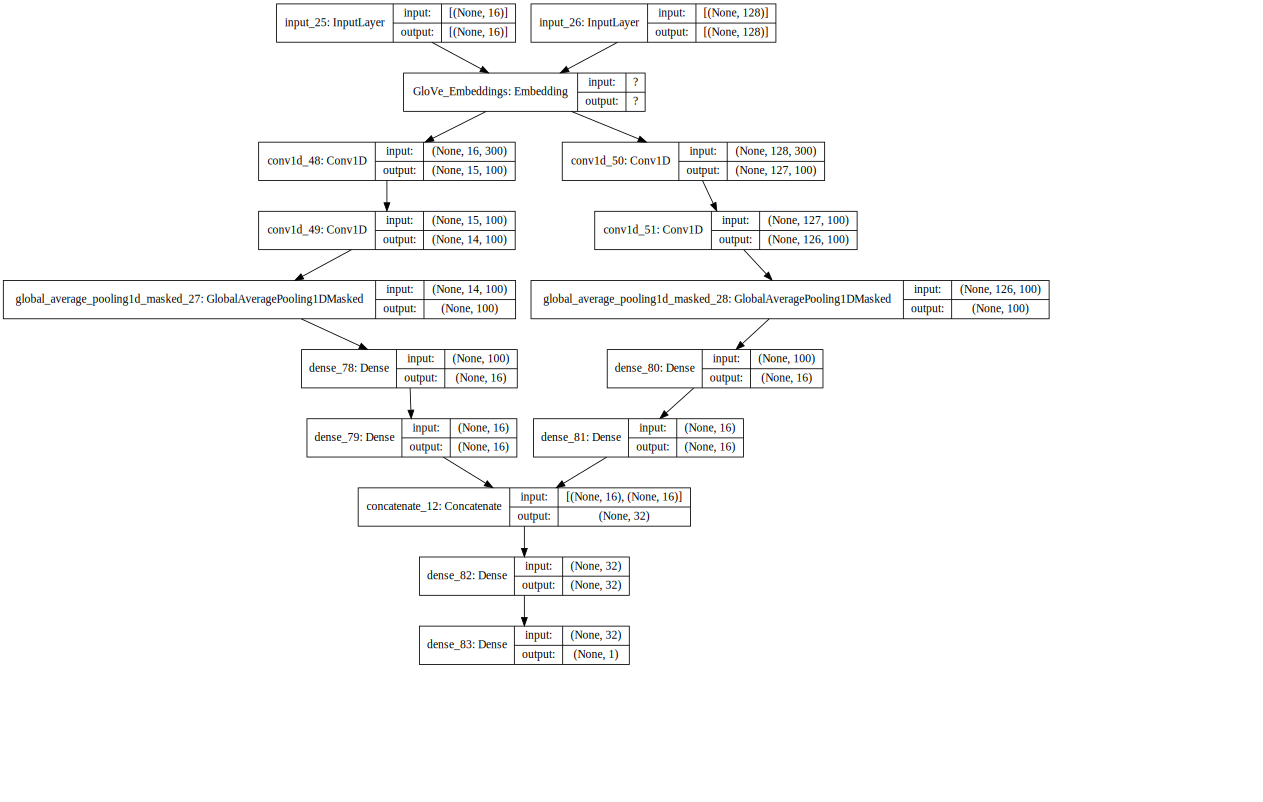

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model3b, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

In [ ]:
#Training to monitor the model loss and accuracy on validation set
history3b = model3b.fit([x_train_topic_pad_glove, x_train_tweet_pad_glove], y_train, epochs=200, batch_size=512, validation_data=([x_dev_topic_pad_glove, x_dev_tweet_pad_glove], y_dev), verbose=1)

Epoch 1/200
35/35 [==============================] - 2s 37ms/step - loss: 0.6601 - accuracy: 0.5533 - val_loss: 0.5883 - val_accuracy: 0.7442
Epoch 2/200
35/35 [==============================] - 1s 30ms/step - loss: 0.5099 - accuracy: 0.7944 - val_loss: 0.5723 - val_accuracy: 0.7442
Epoch 3/200
35/35 [==============================] - 1s 30ms/step - loss: 0.5051 - accuracy: 0.7967 - val_loss: 0.5729 - val_accuracy: 0.7442
Epoch 4/200
35/35 [==============================] - 1s 31ms/step - loss: 0.5078 - accuracy: 0.7943 - val_loss: 0.5746 - val_accuracy: 0.7442
Epoch 5/200
35/35 [==============================] - 1s 30ms/step - loss: 0.5061 - accuracy: 0.7952 - val_loss: 0.5730 - val_accuracy: 0.7442
Epoch 6/200
35/35 [==============================] - 1s 30ms/step - loss: 0.5147 - accuracy: 0.7883 - val_loss: 0.5713 - val_accuracy: 0.7442
Epoch 7/200
35/35 [==============================] - 1s 30ms/step - loss: 0.5122 - accuracy: 0.7897 - val_loss: 0.5711 - val_accuracy: 0.7442
Epoch 

In [ ]:
#testing
results = model3b.evaluate([x_test_topic_pad_glove, x_test_tweet_pad_glove], y_test)
print(results)

194/194 [==============================] - 1s 4ms/step - loss: 1.3849 - accuracy: 0.7625
[1.384888768196106, 0.762489914894104]


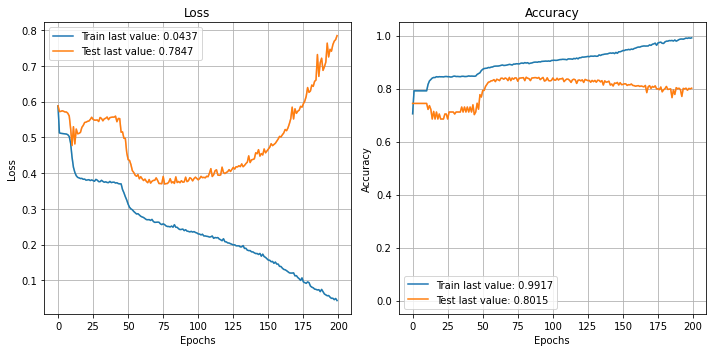

In [ ]:
#plot
plot_history(history3b.history, path="standard.png")
plt.show()